## Project Overview 

Credit default risk is the risk that a lender takes the chance that a borrower fails to make required payments of the loan. 




In [13]:
# import libraries and packages 
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import streamlit as st
from scipy.stats import uniform, randint
from sklearn import model_selection,linear_model, metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import xgboost as xgb
import seaborn as sns

In [14]:
credit_df = pd.read_csv(
    r"C:\Users\somya\Somya Katoch Project 2\credit_risk_dataset.csv\credit_risk_dataset.csv"
)


In [15]:
# check the data size
credit_df.shape

(32581, 12)

In [16]:
Nan_per = credit_df.isnull().sum()/credit_df.shape[0]*100
Nan_per.round(2)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

In [17]:
credit_df.shape

(32581, 12)

**Obeservation:** 
* Only two columns of data contains NaN, 
* `person_emp_length` contains **2.75%** NaN and `loan_int_rate` contains **9.56%** NaN

In [18]:
# check the mode, median for the two features
print('person_emp_length mode {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length median {}'.format(credit_df['person_emp_length'].median()))
print('loan_int_rate mode {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate median {}'.format(credit_df['loan_int_rate'].median()))

person_emp_length mode 0.0
person_emp_length median 4.0
loan_int_rate mode 7.51
loan_int_rate median 10.99


In [19]:
# fill NaN with the mode
credit_df['person_emp_length'] = credit_df['person_emp_length'].fillna(
    credit_df['person_emp_length'].mode()[0]
)
credit_df['loan_int_rate'] = credit_df['loan_int_rate'].fillna(
    credit_df['loan_int_rate'].median()
)


In [20]:
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [21]:
# numerical variables
num_cols = pd.DataFrame(
    credit_df[credit_df.select_dtypes(include=['float', 'int']).columns]
)

# print the numerical variables
num_cols.columns


Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

## Data Analysis 

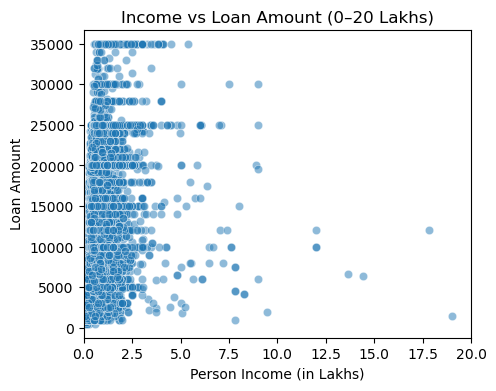

In [22]:
plt.figure(figsize=(5,4))

sns.scatterplot(
    x=credit_df['person_income'] / 1e5,   # convert to lakhs
    y=credit_df['loan_amnt'],
        alpha=0.5

)

plt.xlim(0, 20)   # 🔍 zoom between 10–20 lakhs
plt.xlabel('Person Income (in Lakhs)')
plt.ylabel('Loan Amount')
plt.title('Income vs Loan Amount (0–20 Lakhs)')
plt.show()



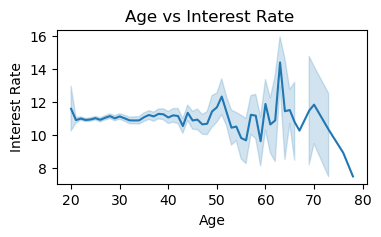

In [23]:
plt.figure(figsize=(4,2))

# normal data (Age < 80)
sns.lineplot(
    data=credit_df[credit_df['person_age'] < 80],
    x='person_age',
    y='loan_int_rate',
)


plt.xlabel('Age')
plt.ylabel('Interest Rate')
plt.title('Age vs Interest Rate ')
plt.show()


* Till the age of 45 the average rate of interest is arount 11%, it fluctuates between 8% - 14% in the age group of 60-80.  

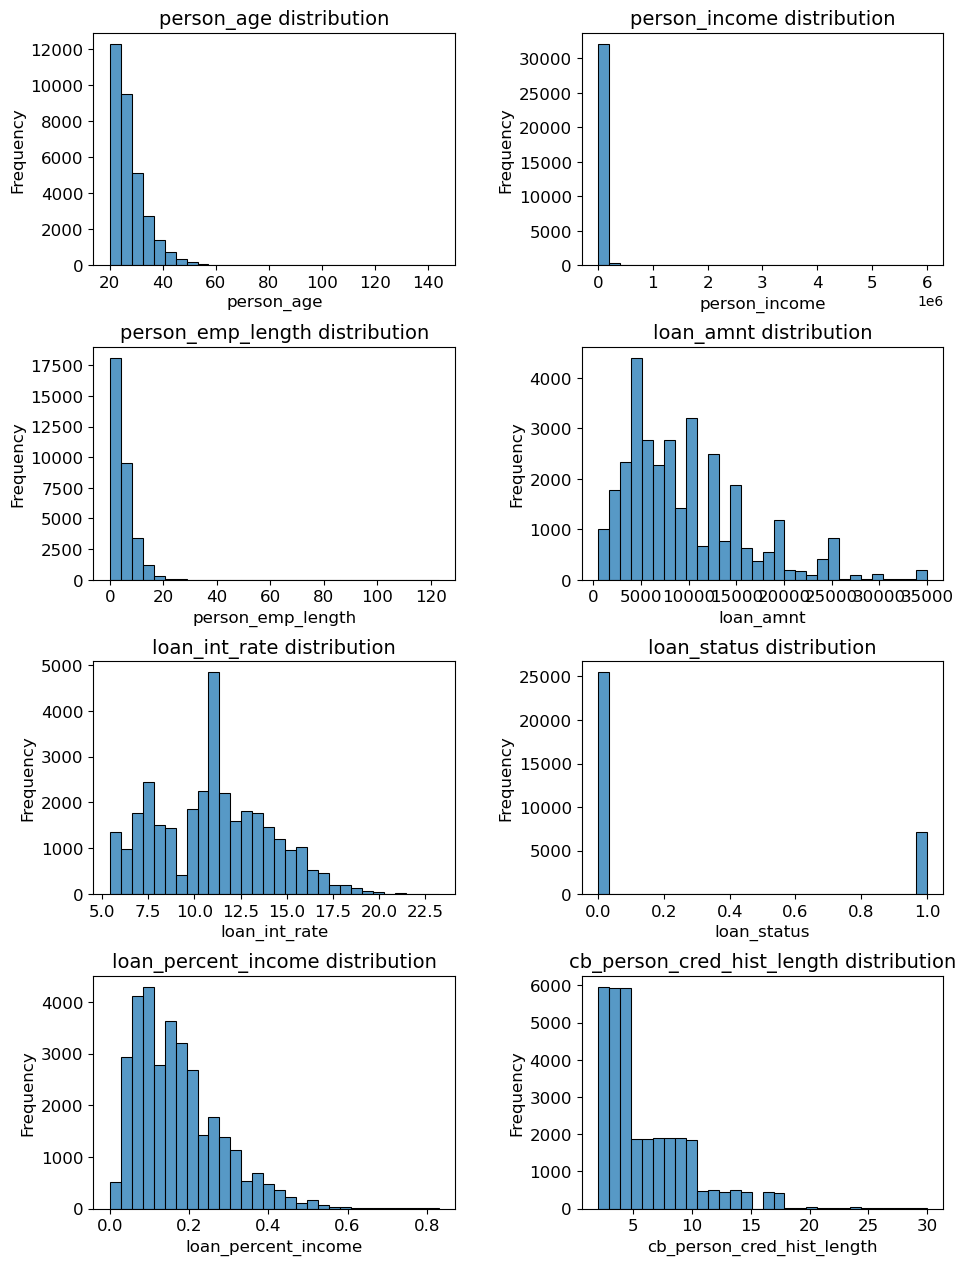

In [24]:
# Select numeric columns
num_cols_hist = credit_df.select_dtypes(include='number')

plt.figure(figsize=(10, 14))

rows, cols = 4, 2

for i, col in enumerate(num_cols_hist.columns):
    plt.subplot(rows, cols, i + 1)
    
    sns.histplot(num_cols_hist[col], bins=30)
    
    plt.title(f'{col} distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95,
    hspace=0.35, wspace=0.35
)

plt.show()


In [25]:
# decribe the dataset
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.658114,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.159669,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


**Observation:** 
* All of the distributions are positive skewed.

* `person_age`: Most people are in the age group of 25- 45 years .  
* `person_emp_length`: Most people have less than 40 years of employment.
* 75% of people have loan amount greater than 1 lakh .


In [26]:
# clean the dataset and drop outliers
cleaned_credit_df = credit_df[credit_df['person_age']<=100]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_emp_length']<=60]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_income']<=4e6]

In [27]:
# get the cleaned numberical variebles
cleaned_num_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['float', 'int']).columns])

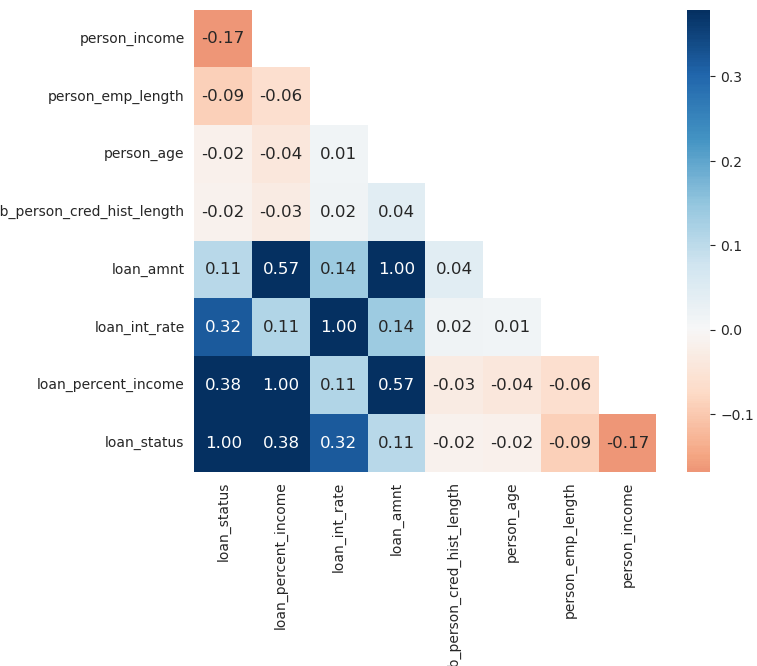

In [28]:
corr = cleaned_num_cols.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 12})

**Observation:** 

* `person_income`, `person_emp_length`, and `person_age`: has negative effect on loan_status being default, which means the larger these variebles, the less likely the person is risky.
* `loan_percent_income`, `loan_int_rate`, and `loan_amnt`: has postive effect on loan_status being default, which means the larger these variebles, the more likely the person is risky.

In [29]:
# get the categorical variebles 
cat_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

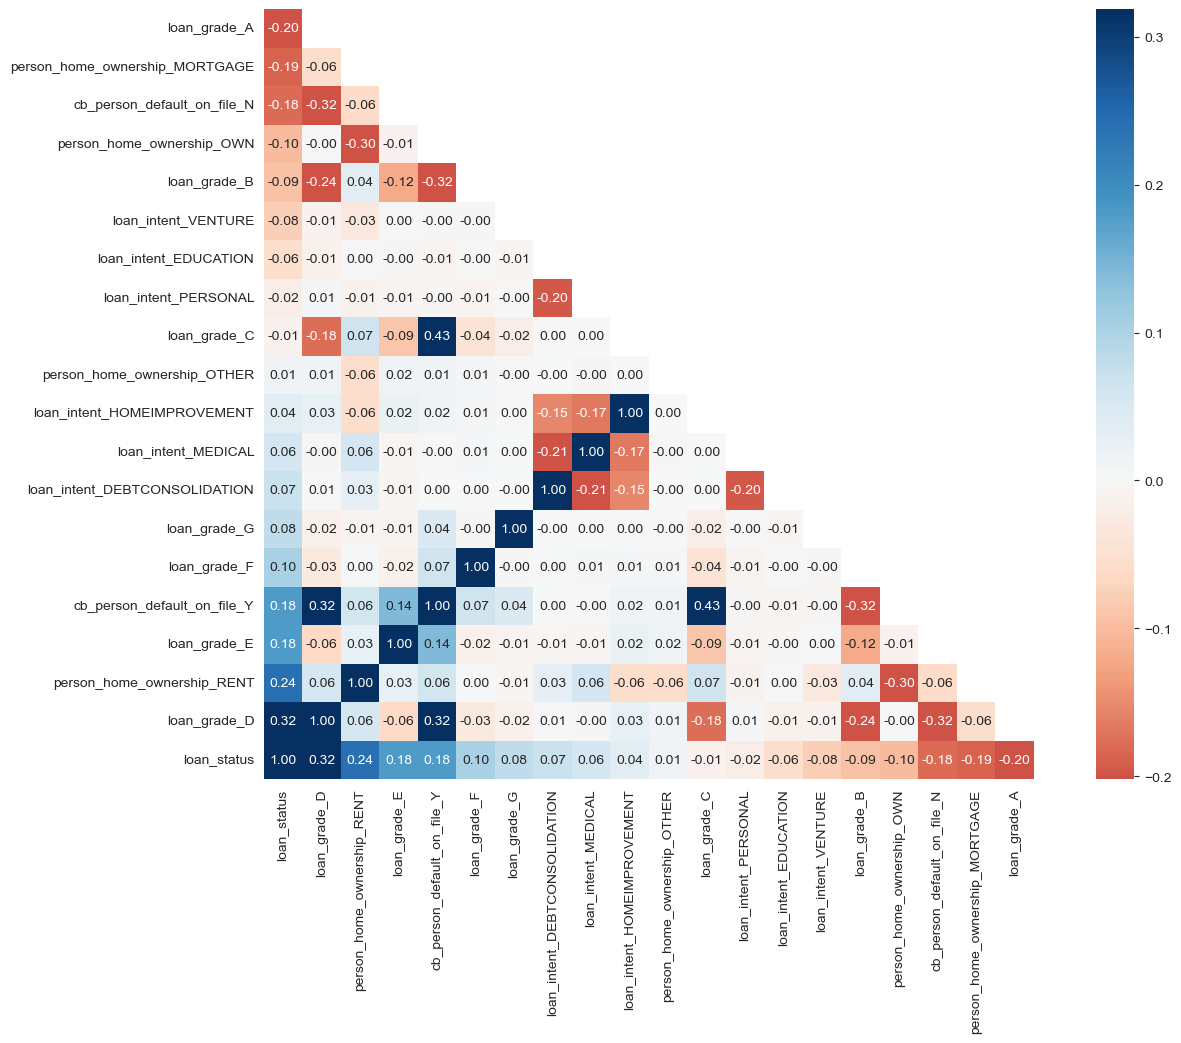

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ One-hot encode categorical columns
encoded_cat_cols = pd.get_dummies(cat_cols)

# 2️⃣ Combine with target variable
cat_cols_corr = pd.concat(
    [encoded_cat_cols, cleaned_credit_df['loan_status']],
    axis=1
)

# 3️⃣ Correlation matrix
corr = cat_cols_corr.corr()

# 4️⃣ Sort by loan_status correlation
corr = corr.sort_values('loan_status', axis=0, ascending=True)
corr = corr.sort_values('loan_status', axis=1, ascending=False)

# 5️⃣ Mask upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# 6️⃣ Plot heatmap
with sns.axes_style("white"):
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        corr,
        mask=mask,
        vmin=corr['loan_status'].min(),
        vmax=corr.drop('loan_status', axis=0)['loan_status'].max(),
        square=True,
        annot=True,
        fmt='.2f',
        center=0,
        cmap='RdBu',
        annot_kws={"size": 10}
    )
    plt.show()


In [31]:
# concat the numerical and one-hot encoded categorical variebles
cleaned_credit_df = pd.concat([cleaned_num_cols, encoded_cat_cols], axis=1)
cleaned_credit_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,False,False,...,False,False,True,False,False,False,False,False,True,False
2,25,9600,1.0,5500,12.87,1,0.57,3,True,False,...,False,False,False,True,False,False,False,False,True,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,False,False,False,True,False,False,False,False,True,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,False,False,False,True,False,False,False,False,False,True
5,21,9900,2.0,2500,7.14,1,0.25,2,False,False,...,True,True,False,False,False,False,False,False,True,False


In [32]:
# check the cleaned dataset size 
print ('The cleaned dataset has {} rows and {} columns'.format(cleaned_credit_df.shape[0], 
                                                               cleaned_credit_df.shape[1]))
print ('The cleaned dataset has {} numerical features and {} categorical features'
       .format(len(cleaned_num_cols.columns)-1, len(encoded_cat_cols.columns)))

The cleaned dataset has 32574 rows and 27 columns
The cleaned dataset has 7 numerical features and 19 categorical features


# Modeling 

In [33]:
# check the cleaned dataset size 
print ('The cleaned dataset has {} rows and {} columns'.format(cleaned_credit_df.shape[0], 
                                                               cleaned_credit_df.shape[1]))
print ('The cleaned dataset has {} numerical features and {} categorical features'
       .format(len(cleaned_num_cols.columns)-1, len(encoded_cat_cols.columns)))

The cleaned dataset has 32574 rows and 27 columns
The cleaned dataset has 7 numerical features and 19 categorical features


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



In [35]:
X = cleaned_credit_df.drop('loan_status', axis=1)
y = cleaned_credit_df['loan_status']


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [37]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [38]:
from sklearn.metrics import classification_report

def model_assess(model, name='Default'):
    '''
    This function is used to test model performance
    '''
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print(f'\n{name}')
    print(classification_report(y_test, preds))


### Evaluate different algorithms

In [39]:
# KNN
knn = KNeighborsClassifier(n_neighbors=150)

# Logistic Regression
lg = LogisticRegression(random_state=42, max_iter=1000)

# Decision Tree
D_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# XGBoost
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    eval_metric='logloss'
)


In [40]:
model_assess(knn, 'KNN')
model_assess(lg, 'Logistic Regression')
model_assess(D_tree, 'Decision Tree')
model_assess(xgb_model, 'XGBoost')



KNN
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5094
           1       0.85      0.43      0.57      1421

    accuracy                           0.86      6515
   macro avg       0.85      0.71      0.75      6515
weighted avg       0.86      0.86      0.84      6515


Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      5094
           1       0.77      0.54      0.63      1421

    accuracy                           0.86      6515
   macro avg       0.82      0.75      0.78      6515
weighted avg       0.86      0.86      0.85      6515


Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5094
           1       0.96      0.70      0.81      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.84      0.88      6515
weighted avg       0.93      0.93

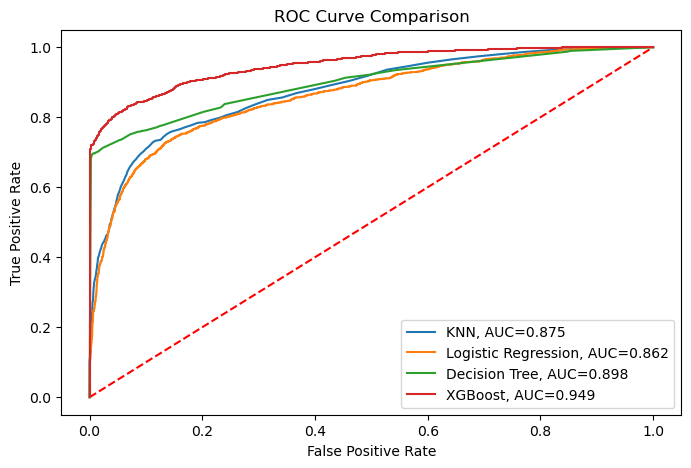

In [41]:
fig = plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], 'r--')

# KNN
probs_knn = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs_knn)
plt.plot(fpr, tpr, label=f'KNN, AUC={roc_auc_score(y_test, probs_knn):.3f}')

# Logistic Regression
probs_lg = lg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs_lg)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC={roc_auc_score(y_test, probs_lg):.3f}')

# Decision Tree
probs_dt = D_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs_dt)
plt.plot(fpr, tpr, label=f'Decision Tree, AUC={roc_auc_score(y_test, probs_dt):.3f}')

# XGBoost
probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs_xgb)

plt.plot(fpr, tpr, label=f'XGBoost, AUC={roc_auc_score(y_test, probs_xgb):.3f}')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [42]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
})

new_features_df = feature_importance[
    feature_importance['importance'] > 0
].sort_values(by='importance', ascending=False)


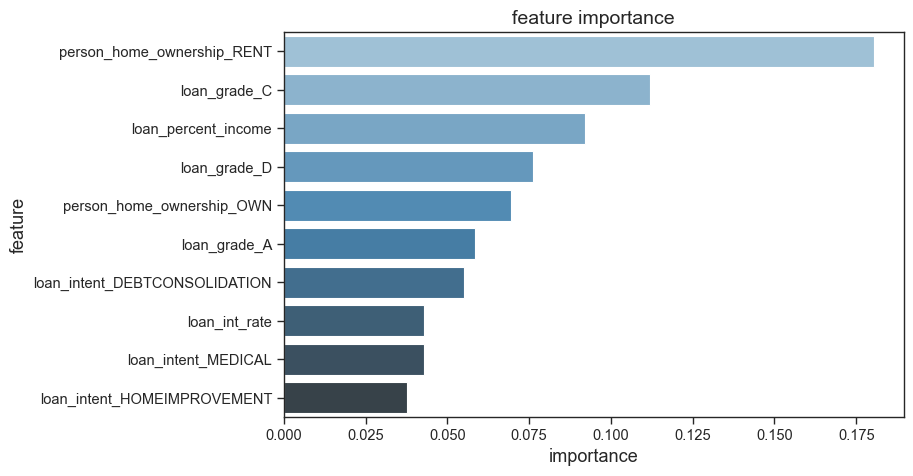

In [43]:
sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()



In [44]:
new_features_df


,feature,importance
10,person_home_ownership_RENT,0.180480
19,loan_grade_C,0.112085
5,loan_percent_income,0.092218
20,loan_grade_D,0.076219
9,person_home_ownership_OWN,0.069485
17,loan_grade_A,0.058361
11,loan_intent_DEBTCONSOLIDATION,0.054964
4,loan_int_rate,0.042828
14,loan_intent_MEDICAL,0.042821
13,loan_intent_HOMEIMPROVEMENT,0.037578


In [45]:
from xgboost import XGBClassifier
xgb_model = xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [46]:
from scipy.stats import randint, uniform

params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Random_CV = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    random_state=42,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=16,
    return_train_score=True
)

Random_CV.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
# function to return the top selcted models
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report_best_scores(Random_CV.cv_results_, 3)

In [ ]:
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

xgb_base.fit(X_train, np.ravel(y_train))



In [ ]:
preds_proba_xgb = xgb_base.predict_proba(X_test)
probs_xgb = preds_proba_xgb[:, 1]
aucxgb = roc_auc_score(y_test, probs_xgb)


In [ ]:
print(f"xgb base model AUROC score: {aucxgb:.4f}")
print(f"xgb best model using RandomizedSearchCV AUROC score: {Random_bestauc:.4f}")


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(
    objective="binary:logistic",   # change if needed
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)


In [ ]:
Grid_CV = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    cv=3,
    verbose=1,
    n_jobs=16,
    return_train_score=True
)

Grid_CV.fit(X_train, y_train)


In [ ]:
report_best_scores(Grid_CV.cv_results_, )

In [ ]:
Grid_best_xgb = Grid_CV.best_estimator_
Grid_best_xgb.fit(X_train, np.ravel(y_train)) 
preds_proba_Grid = Grid_best_xgb.predict_proba(X_test)
probs_Grid = preds_proba_Grid[:, 1]
Grid_bestauc = roc_auc_score(y_test, probs_Grid)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))
print ('xgb best model using GridSearchCV AUROC socre: {}'.format(Grid_bestauc))

In [ ]:
# display feature and their importance of the best model
feature_importance = pd.DataFrame({'feature': x_train.columns, 
                                   'importance': Grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

In [ ]:
# display the top 10 important features
new_features_df.head(10)

**Observation**

The top 5 important features includes:
* `person_home_ownership_RENT`
* `person_home_ownership_OWN`
* `loan_grade_C`
* `loan_percent_income`
* `person_home_ownership_MORTGAGE`**Observation**

The top 5 important features includes:
* `person_home_ownership_RENT`
* `person_home_ownership_OWN`
* `loan_grade_C`
* `loan_percent_income`
* `person_home_ownership_MORTGAGE`

In [ ]:
# select the top 20 features and then retrain the model
new_features = new_features_df['feature'][0:20]
new_features

In [ ]:
# Split Train and Test Sets
new_features_df = pd.DataFrame(cleaned_credit_df[new_features])
new_features_df.shape

In [ ]:
# Align the label with the features
y = credit_df.loc[new_features_df.index, 'loan_status']
X = new_features_df

from sklearn.model_selection import train_test_split

X_train1, x_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print('The train dataset has {} data\nThe test dataset has {} data'.format(
    X_train1.shape[0], x_test1.shape[0]
))


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',  # or 'mlogloss' if multi-class
    random_state=42
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1
    "gamma": uniform(0.2, 0.3),            # 0.2-0.5
    "learning_rate": uniform(0.2, 0.2),    # 0.2-0.4
    "max_depth": randint(4, 6),            # 4, 5
    "n_estimators": randint(100, 300),     # 100-300
    "subsample": uniform(0.9, 0.1)         # 0.9-1
}

Random_CV = RandomizedSearchCV(
    estimator=xgb_model,          # ✅ pass the model object, not the module
    param_distributions=params,
    random_state=42,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=16,
    return_train_score=True
)

Random_CV.fit(x_train1, y_train1)

In [ ]:
report_best_scores(Random_CV.cv_results_, 3)

In [ ]:
# Fit the model on the train split
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(x_train1, y_train1)   # ✅ use x_train1, y_train1

# Predict on the corresponding test split
preds_proba_Random = Random_best_xgb.predict_proba(x_test1)  
probs_Random = preds_proba_Random[:, 1]

# AUROC
from sklearn.metrics import roc_auc_score
Random_bestauc = roc_auc_score(y_test1, probs_Random)

print('xgb best model using RandomizedSearchCV AUROC score: {:.4f}'.format(Random_bestauc))

**Observation**

it turns out after dropping some features, the model is only improved to 0.955, thus no furhter GridSearchCV is performed. And the original GridSearchCV best model will be used for futher threshhold optimizaiton. 

### Threshold Optimization

In [ ]:
preds = Grid_best_xgb.predict_proba(X_test) # 1st col = pred val, 2nd col = pred prob

pred_probs = pd.DataFrame(preds[:,1],columns = ['Default Probability'])

pd.concat([pred_probs, y_test.reset_index(drop=True)],axis=1)
thresh = np.linspace(0,1,41)
thresh

In [ ]:
def optimize_threshold(predict,thresholds =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thresholds:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'], zero_division=0)
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls = optimize_threshold(pred_probs)


In [ ]:
figure = plt.subplots(figsize=(8, 6))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

In [ ]:
optim_threshold = accs.index(max(accs))

print('The model accuracy is {} using the optimal probabilty threshold'
      .format(round(accs[optim_threshold],3)))

print ('The optimal probabilty threshold is {}'.format(thresh[optim_threshold]))

** Discussion**

* The XGBClassifier has the best performance with 0.954 AUROC score compared to other three classifiers KNN, Logistic regression, and decision tree using the base model.

* Using RandomizedSearchCV to fast optimize hyperparamters, the model AUROC is improved to 0.9563

* With further fine tuning around those hyperparameters using GridSearchCV, the final best model has a 0.9571 AUROC score. 

* The optimal probability threshold for the best model is 0.55 resulting accuracy 0.939.



In [ ]:
import pickle

print(type(final_model))   # sanity check

with open("xgb_credit_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Model saved successfully")
